In [35]:
!pip install mlxtend

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import linear_model, decomposition, datasets
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import math
from mlxtend.plotting import plot_confusion_matrix

In [11]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [12]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
11047484,RACV,BOURKE STREET,QUEEN STREET,ELIZABETH STREET,3,2392N,26/08/2012 10:44:54 AM,26/08/2012 11:49:49 AM,3895,1P SUN 7:30-18:30,0,123,4952
7131487,CHINATOWN,RUSSELL STREET,LT BOURKE STREET,BOURKE STREET,5,775W,30/04/2012 02:44:18 PM,30/04/2012 03:16:11 PM,1913,1/2P MTR M-SAT 7:30-19:30,0,1221,497
640702,MAGISTRATES,LA TROBE STREET,SPENCER STREET,KING STREET,3,3964N,19/10/2011 01:03:16 PM,19/10/2011 01:08:11 PM,295,2P TKT A M-SAT 7:30-20:30,0,856,2271
3210734,SUPREME,LONSDALE STREET,WILLIAM STREET,QUEEN STREET,3,3090N,30/12/2011 11:00:06 AM,30/12/2011 11:03:30 AM,204,2P DIS AOT 00:00-16:00,0,894,1851
8915854,RIALTO,KING STREET,LT COLLINS STREET,COLLINS STREET,5,1433W,23/06/2012 09:16:41 AM,23/06/2012 09:18:06 AM,85,1P MTR SAT 7:30-19:30,0,839,5042


In [13]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [14]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [15]:
#check which columns have missing values
parkingdata.columns[parkingdata.isnull().any()]

Index([], dtype='object')

In [16]:
#Target field identification
duration = parkingdata['Duration of Parking Event (in seconds)'].copy()

print('Minimum parking duration (seconds): ' + str(duration.min()))
print('Maximum parking duration (seconds): ' + str(duration.max()))
print('\nMinimum parking duration (hour): ' + str(duration.min()/3600))
print('Maximum parking duration (hour): ' + str(duration.max()/3600))
print('\nMinimum parking duration is under [' + str(math.trunc(duration.min()/3600) + 1) + '] hours')
print('Maximum parking duration is under [' + str(math.trunc(duration.max()/3600) + 1) + '] hours')

durList = []
static = 1
df = pd.DataFrame()

for record in duration.values:
    hour = 3600
    index = 0
    while static == 1:
        if record < hour:
#             print("\nDuration in seconds: " + str(record))
            data = math.trunc(record/3600) + 1
            durList.append(data)
#             print("Duration is under " + str(data) + " hours")
            break
        else:
            hour += 3600

df.insert(0, 'Duration (Hours)', durList, True)
target = df['Duration (Hours)']
target.head(10)

Minimum parking duration (seconds): 7
Maximum parking duration (seconds): 86265

Minimum parking duration (hour): 0.0019444444444444444
Maximum parking duration (hour): 23.9625

Minimum parking duration is under [1] hours
Maximum parking duration is under [24] hours


0    2
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Duration (Hours), dtype: int64

In [17]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('In Violation?', axis = 1, inplace = True)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['In Violation?'] = parkingdata['In Violation?']
features['Side Of Street'] = parkingdata['Side Of Street']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,In Violation?,Side Of Street,Street ID,Device ID,Arrival Hour,Departure Hour
11047484,0,0,0,0,0,0,3,123,4952,10,11
7131487,1,1,1,1,1,0,5,1221,497,14,15
640702,2,2,2,2,2,0,3,856,2271,13,13
3210734,3,3,3,3,3,0,3,894,1851,11,11
8915854,4,4,4,4,4,0,5,839,5042,9,9
7012810,5,5,5,5,5,0,3,924,2619,13,13
560777,4,6,6,6,6,0,4,528,1293,14,14
4550994,6,7,7,7,7,0,4,669,1391,19,19
4630878,7,8,8,8,0,0,3,926,1692,15,15
9008560,8,9,9,9,8,0,1,1175,4156,12,12


In [18]:
#Parameter Tuning

#Define the parameters to tune and the values to tune to
params_randomforest = [
                { 
                   'n_estimators' : (10,20,30,50,70,90,100),
                    'criterion' : ('gini', 'entropy'),
                    'max_depth' : (3, 5, 7, 9, 10, 15),
                    'max_features' : ('auto', 'sqrt'),
                    'min_samples_split' : (2, 4, 6, 8, 10, 14, 16)
                    
                }
            ]

In [19]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_randomforest = GridSearchCV(RandomForestClassifier(), 
                      param_grid = params_randomforest, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [20]:
#Fit the model with the dataset
bestModel = gs_randomforest.fit(features, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  5

In [21]:
gs_randomforest.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_split': 6,
 'n_estimators': 90}

In [22]:
#Find the best values for the  parameters of the model (Formatted output)
best_e = bestModel.best_estimator_.get_params()['n_estimators']
best_C = bestModel.best_estimator_.get_params()['criterion']
best_maxd =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf =  bestModel.best_estimator_.get_params()['max_features']
best_mins =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimator:', best_e)
print('Best criterion:', best_C)
print('Best max depth:', best_maxd)
print('Best max features:', best_maxf)
print('Best min_samples_split:', best_mins)

Best estimator: 90
Best criterion: entropy
Best max depth: 15
Best max features: sqrt
Best min_samples_split: 6


In [23]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.7991
1,gini,3,auto,2,20,0.7954
2,gini,3,auto,2,30,0.7934
3,gini,3,auto,2,50,0.7983
4,gini,3,auto,2,70,0.7946
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.8427
1172,entropy,15,sqrt,16,50,0.8425
1173,entropy,15,sqrt,16,70,0.8432
1174,entropy,15,sqrt,16,90,0.8429


In [24]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
randomforest = metric = RandomForestClassifier(n_estimators = best_e, 
                               criterion = best_C, 
                               max_depth = best_maxd, 
                               max_features = best_maxf,
                               min_samples_split = best_mins                
                               )

In [25]:
# Hill climbing w/ Randomforest
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = randomforest.fit(x_train, y_train)
    cur_Score = randomforest.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.7825
Score with 2 selected features: 0.7835
Score with 3 selected features: 0.784
Score with 4 selected features: 0.809

Indexs of the desired features
[2, 6, 0, 5]


In [26]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Side Of Street,Area Name,In Violation?
11047484,0,3,0,0
7131487,1,5,1,0
640702,2,3,2,0
3210734,3,3,3,0
8915854,4,5,4,0
7012810,5,3,5,0
560777,6,4,4,0
4550994,7,4,6,0
4630878,8,3,7,0
9008560,9,1,8,0


In [27]:
bestModel = gs_randomforest.fit(features_hc, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  3

In [28]:
gs_randomforest.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_split': 6,
 'n_estimators': 30}

In [29]:
best_e_hc = bestModel.best_estimator_.get_params()['n_estimators']
best_C_hc = bestModel.best_estimator_.get_params()['criterion']
best_maxd_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf_hc =  bestModel.best_estimator_.get_params()['max_features']
best_mins_hc =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimators:', best_e_hc)
print('Best criterion:', best_C_hc)
print('Best max depth:', best_maxd_hc)
print('Best max features:', best_maxf_hc)
print('Best min_samples_split:', best_mins_hc)

Best estimators: 30
Best criterion: gini
Best max depth: 15
Best max features: auto
Best min_samples_split: 6


In [30]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8075
1,gini,3,auto,2,20,0.8057
2,gini,3,auto,2,30,0.8087
3,gini,3,auto,2,50,0.8034
4,gini,3,auto,2,70,0.8078
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.8235
1172,entropy,15,sqrt,16,50,0.8212
1173,entropy,15,sqrt,16,70,0.8212
1174,entropy,15,sqrt,16,90,0.8229


In [31]:
randomforest = metric = RandomForestClassifier(n_estimators = best_e_hc, 
                               criterion = best_C_hc, 
                               max_depth = best_maxd_hc, 
                               max_features = best_maxf_hc,
                               min_samples_split = best_mins_hc                
                               )

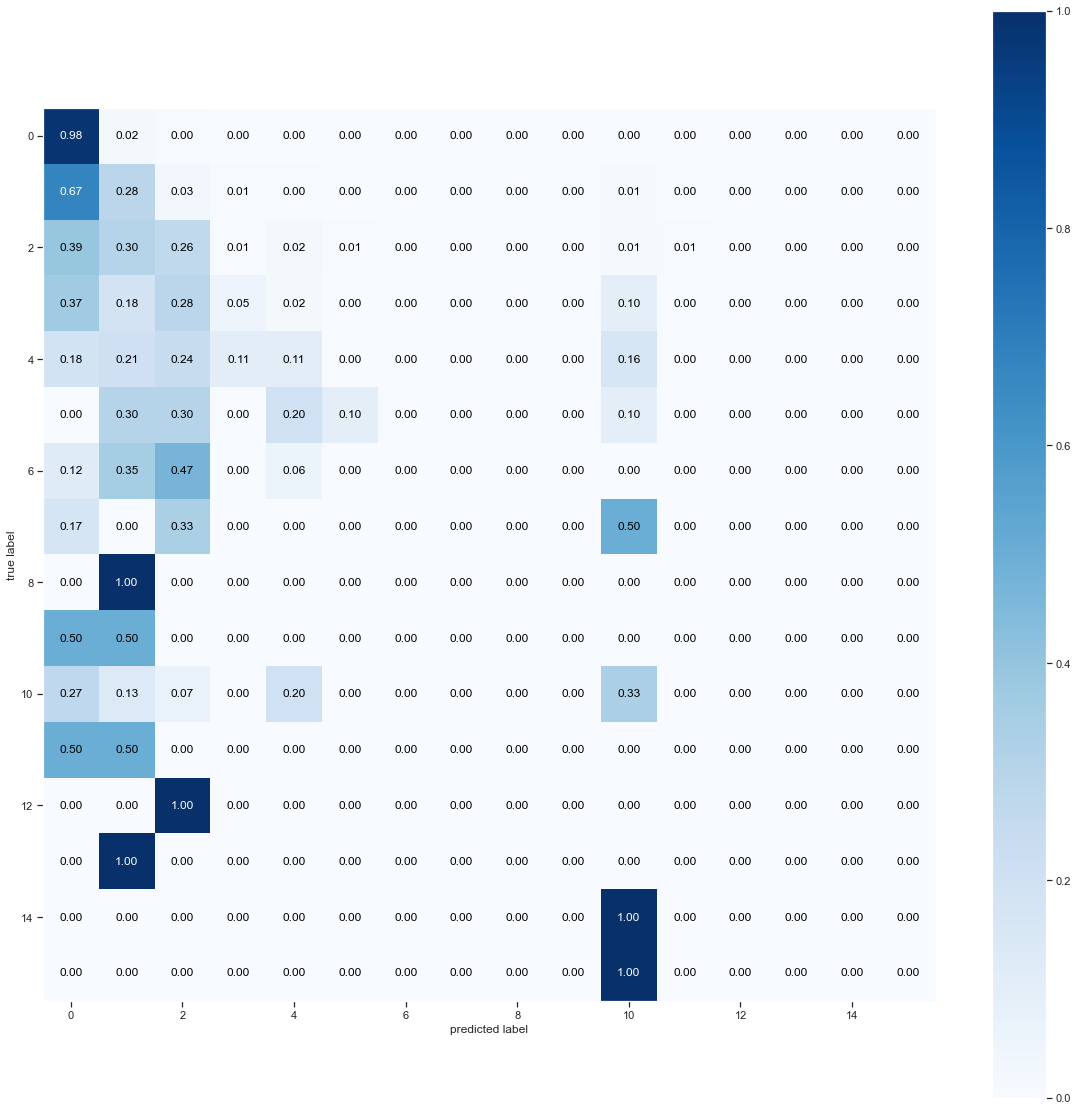

In [37]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
randomforest.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = randomforest.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               figsize=(20, 20))
plt.show()

In [38]:
def precision(label, cm):
    col = cm[:, label]
    return cm[label, label] / col.sum()
    
def recall(label, cm):
    row = cm[label, :]
    return cm[label, label] / row.sum()

def precision_macro_average(cm):
    rows, columns = cm.shape
    sum_of_precisions = 0
    for label in range(5):
        sum_of_precisions += precision(label, cm)
    return sum_of_precisions / rows

def recall_macro_average(cm):
    rows, columns = cm.shape
    sum_of_recalls = 0
    for label in range(5):
        sum_of_recalls += recall(label, cm)
    return sum_of_recalls / columns

In [39]:
print("label precision recall f-score")
ftot=0
for label in range(5):
    p = precision(label, cm)
    r = recall(label, cm)
    fs = (2*p*r)/(p+r)
    ftot +=fs
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f} {fs:3.3f}")

label precision recall f-score
    0     0.864  0.977 0.917
    1     0.582  0.282 0.380
    2     0.346  0.262 0.298
    3     0.176  0.050 0.078
    4     0.222  0.105 0.143


In [40]:
print("precision total:", precision_macro_average(cm))

print("recall total:", recall_macro_average(cm))

print("F-score total:", (ftot/5))

precision total: 0.13690262007036721
recall total: 0.10472659536472917
F-score total: 0.3630876140956353


In [41]:
def accuracy(cm):
    diagonal_sum = cm.trace()
    sum_of_all_elements = cm.sum()
    return diagonal_sum / sum_of_all_elements 
print("\n Accuracy score: {:.5f}".format(accuracy(cm)))


 Accuracy score: 0.82060


In [42]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    randomforest.fit(x_train, y_train)
    kFoldTotal += randomforest.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, randomforest.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.82500
[fold 1] score: 0.82250
[fold 2] score: 0.82850
[fold 3] score: 0.81650
[fold 4] score: 0.83000

KNN mean score [5 folds] = 0.8245
